In [5]:
from math import factorial, exp
import matplotlib.pyplot as plt
import numpy as np

def offeredTraffic(calls_per_hour, hours_per_call): # A0
    return calls_per_hour*hours_per_call

def erlangB(n, A0):
    denom = 0
    for i in range(n+1):
        denom += (A0**i)/(factorial(i))
    E1 = ((A0**n)/factorial(n))/denom
    return E1

# def erlangC(n, A0):
#     denom = ((A0**n)/factorial(n))*(n/(n-A0))
#     for i in range(n):
#         denom += (A0**i)/factorial(i)
#     return ((A0**n)/factorial(n))*(n/(n-A0))/denom

def erlangC(n, A0):
    denomSum = 0
    for i in range(n):
        denomSum += (A0**i)/factorial(i)
    denom = A0**n + factorial(n)*(1-A0/n)*denomSum
    return (A0**n)/denom

def meanCallDelay(n, A0, meanCallDuration, probDelay):
    # print(probDelay)
    return probDelay*meanCallDuration/(n-A0)

def meanQueuedDelay(n, A0, meanCallDuration):
    return meanCallDuration/(n-A0)

def erlangC_GOS(n, A0, meanCallDuration, probDelay, maxDelay=0):
    return probDelay*exp(-(n-A0)*maxDelay/meanCallDuration)


In [62]:
def trafficSimulation(numChannels, numCalls, meanCallDuration, requeue=False, maxDelay=0, holdingDistrib='exp', repetitions=1):

    totalFailRate, totalFailCount = 0, 0
    totalProbDelay, totalDelayCount, totalDelay = 0, 0, 0
    for j in range(repetitions):

        if holdingDistrib == 'exp':
            callDurations = np.random.exponential(scale=meanCallDuration, size=numCalls)

        elif holdingDistrib == 'gamma':
            callDurations = np.random.gamma(shape=1.2073, scale=meanCallDuration, size=numCalls)
            callDurations = np.random.gamma(shape=1.2073, scale=0.03205, size=numCalls)  # shape from paper, scale from paper: 0.03205 = muCHT*(muPaper/bPaper) = muCHT * (29.6121/35.875)

        callStarts = np.random.uniform(size=numCalls)
        # callStarts = np.random.poisson(lam=1/(meanCallDuration*3600), size=numCalls)
        # plt.hist(callStarts, 50)
        # plt.show()
        callStarts.sort()
        # Calls = Numpy array of [[call0_start call0_end]; [call1_start call1_end];...
        calls = np.stack((callStarts, np.add(callStarts,callDurations)),axis=1)

        channelFreeTimes = np.zeros(numChannels)
        time = 0
        callsFailed = 0
        callsDelayed = 0
        delay = 0
        for call in calls:
            time = call[0]
            channelFound = False

            for j in range(numChannels):
                if not(channelFound):
                    if channelFreeTimes[j] <= time:
                        channelFreeTimes[j] = call[1]
                        channelFound = True

            if channelFound == False:
                if requeue == False:
                    callsFailed += 1

                else:
                    nextCallFinishTime = channelFreeTimes.min()
                    delay += nextCallFinishTime-call[0]
                    if delay>maxDelay:
                        callsDelayed += 1
                        indices = np.where(channelFreeTimes == nextCallFinishTime)
                        index = indices[0][0]
                        channelFreeTimes[index] = call[1]

        if requeue == False:
            totalFailRate += callsFailed/numCalls
            totalFailCount += callsFailed
        else:
            totalProbDelay += callsDelayed/numCalls
            totalDelayCount += callsDelayed
            totalDelay += delay

    # return means:
    if requeue == False:
        return totalFailRate/repetitions, totalFailCount/repetitions
    else:
        return totalProbDelay/repetitionsPerSimulation, totalDelayCount/repetitionsPerSimulation, totalDelay/repetitionsPerSimulation


In [58]:
meanCallDuration = 2.33/60# 2.33 mins in hrs
n = 57

# minNumCalls = 1
# maxNumCalls = 2000
# numTests = 21
# simulationCallAmounts = np.concatenate((np.linspace(minNumCalls, maxNumCalls, numTests), np.linspace(2500, 6000, 8))).astype(np.int)
simulationCallAmounts = np.linspace(0, 3000, 16).astype(np.int)
# simulationCallAmounts = np.linspace(0, 6000, 31).astype(np.int)
# simulationCallAmounts = np.linspace(1000, 1000, 1).astype(np.int)

repetitionsPerSimulation = 50
print(simulationCallAmounts)

[   0  200  400  600  800 1000 1200 1400 1600 1800 2000 2200 2400 2600
 2800 3000]


# Calls:		Erlang B:		Sim GOS (exp):		Sim GOS (gamma)
0			0.0000			nan			nan
200			0.0000			0.0000			0.0000
400			0.0000			0.0000			0.0000
600			0.0000			0.0000			0.0000
800			0.0009			0.0000			0.0000
1000			0.1297			0.1180			0.1000
1200			1.8990			1.5717			1.7033
1400			7.3822			6.8686			6.6857
1600			14.9891			13.8788			13.8512
1800			22.5874			21.5189			21.4778
2000			29.3855			27.3460			28.1660
2200			35.2733			33.8500			33.7255
2400			40.3416			39.3933			38.7608
2600			44.7179			42.9492			43.5069
2800			48.5202			47.3436			47.0964
3000			51.8471			50.5727			50.2700


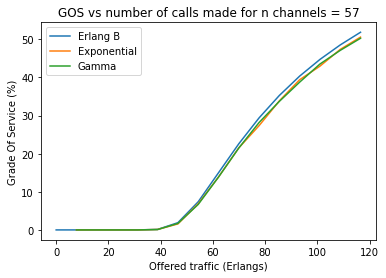

In [63]:
# NO REQUEUING

erlangBs = np.zeros(simulationCallAmounts.shape)
GOS_exp = np.zeros(simulationCallAmounts.shape)
GOS_gamma = np.zeros(simulationCallAmounts.shape)
meanCallDelays = np.zeros(simulationCallAmounts.shape)
meanQueuedDelays = np.zeros(simulationCallAmounts.shape)

print("# Calls:\t\tErlang B:\t\tSim GOS (exp):\t\tSim GOS (gamma)")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100

    meanFailRate_exp,  meanFailCount_exp = trafficSimulation(n, numCalls, meanCallDuration, holdingDistrib='exp', repetitions=repetitionsPerSimulation)
    GOS_exp[i] = meanFailRate_exp*100

    meanFailRate_gamma,  meanFailCount_gamma = trafficSimulation(n, numCalls, meanCallDuration, holdingDistrib='gamma', repetitions=repetitionsPerSimulation)
    GOS_gamma[i] = meanFailRate_gamma*100

    print("{}\t\t\t{:.4f}\t\t\t{:.4f}\t\t\t{:.4f}".format(numCalls,erlangBs[i], GOS_exp[i], GOS_gamma[i]))

plt.plot(offeredTraffic(simulationCallAmounts,meanCallDuration), erlangBs, label='Erlang B')
plt.plot(offeredTraffic(simulationCallAmounts,meanCallDuration), GOS_exp, label='Exponential')
plt.plot(offeredTraffic(simulationCallAmounts,meanCallDuration), GOS_gamma, label='Gamma')

plt.xlabel('Offered traffic (Erlangs)')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made for n channels = "+str(n))
plt.legend()
plt.show()


# Calls:		Erlang C:		Sim GOS (exp):		Sim GOS (gamma)
0			0.000			nan			nan
200			0.000			0.000			0.0000
400			0.000			0.000			0.0000
600			0.000			0.000			0.0000
800			0.002			0.010			0.0000
1000			0.406			0.124			0.2280
1200			9.592			5.710			5.7150
1400			63.306			31.561			34.9171
1600			204.402			68.808			70.9363
1800			445.715			86.410			87.7533
2000			776.860			92.336			93.1150
2200			1181.406			94.185			94.6164
2400			1644.344			95.237			95.2875
2600			2153.672			95.675			95.8523
2800			2700.150			96.205			96.1800
3000			3276.705			96.604			96.4707


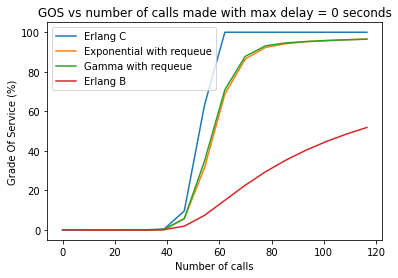

In [66]:
# WITH REQUEUING

erlangCs = np.zeros(simulationCallAmounts.shape)
GOS_exp = np.zeros(simulationCallAmounts.shape)
GOS_gamma = np.zeros(simulationCallAmounts.shape)
# meanCallDelays = np.zeros(simulationCallAmounts.shape)
# meanQueuedDelays = np.zeros(simulationCallAmounts.shape)

maxDelay=0#20/3600

print("# Calls:\t\tErlang C:\t\tSim GOS (exp):\t\tSim GOS (gamma)")
for i, numCalls in enumerate(simulationCallAmounts):

    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangCs[i] = erlangC(n, A0)*100

    meanDelayRate_exp,  meanDelayCount_exp, meanTotalDelay_exp = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, holdingDistrib='exp', repetitions=repetitionsPerSimulation)
    GOS_exp[i] = meanDelayRate_exp*100

    meanDelayRate_gamma,  meanDelayCount_gamma, meanTotalDelay_gamma = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, holdingDistrib='gamma', repetitions=repetitionsPerSimulation)
    GOS_gamma[i] = meanDelayRate_gamma*100

    print("{}\t\t\t{:.3f}\t\t\t{:.3f}\t\t\t{:.4f}".format(numCalls,erlangCs[i], GOS_exp[i], GOS_gamma[i]))


trafficRange = offeredTraffic(simulationCallAmounts,meanCallDuration)
plt.plot(trafficRange, np.clip(erlangCs,0,100), label='Erlang C')
plt.plot(trafficRange, np.clip(GOS_exp,0,100), label='Exponential with requeue')
plt.plot(trafficRange, np.clip(GOS_gamma,0,100), label='Gamma with requeue')
plt.plot(trafficRange, erlangBs, label='Erlang B')
# plt.plot(trafficRange, GOS_simulated, label='Exponential')

plt.xlabel('Number of calls')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made with max delay = {} seconds".format(str(maxDelay*3600)))
plt.legend()
plt.show()


In [ ]:
erlangBs = np.zeros(simulationCallAmounts.shape)
erlangCs = np.zeros(simulationCallAmounts.shape)
meanCallDelays = np.zeros(simulationCallAmounts.shape)
meanQueuedDelays = np.zeros(simulationCallAmounts.shape)
simProbDelay = np.zeros(simulationCallAmounts.shape)
pMaxDelays = np.zeros(simulationCallAmounts.shape)
maxDelay=0#20/3600
print("# Calls:\tErlang C:\tErlang C w/D\tSimulation:\tCall Delays\tQueued Delays\tSim # Delayed:\tSim Delay Durations:")
for i, numCalls in enumerate(simulationCallAmounts):
    A0 = offeredTraffic(numCalls, meanCallDuration)
    erlangBs[i] = erlangB(n, A0)*100
    erlangCs[i] = erlangC(n, A0)*100
    pMaxDelays[i] = erlangC_GOS(n, A0, meanCallDuration, erlangCs[i], maxDelay=maxDelay)
    meanCallDelays[i] = meanCallDelay(n, A0, meanCallDuration,  np.clip(erlangCs,0,100)[i])
    meanQueuedDelays[i] = meanQueuedDelay(n, A0, meanCallDuration)
    
    totalProbDelay, totalDelayCount, totalDelay = 0, 0, 0
    for j in range(repetitionsPerSimulation):
        probDelay, delayCount, delay = trafficSimulation(n, numCalls, meanCallDuration, requeue=True, maxDelay=maxDelay)
        totalProbDelay += probDelay
        totalDelayCount += delayCount
        totalDelay += delay
    meanProbDelay = totalProbDelay/repetitionsPerSimulation
    meanDelayCount = totalDelayCount/repetitionsPerSimulation
    meanDelay = totalDelay/repetitionsPerSimulation
    simProbDelay[i] = meanProbDelay*100
    # print("Call fail rate in {} simulations = {}% (mean of {} fails in {} calls)\n".format(repetitionsPerSimulation, GOS_simulated[i], meanFailCount, numCalls))


# for i, numCalls in enumerate(simulationCallAmounts):
    print("{}\t\t{:.2f}\t\t{:.2f}\t\t{:.2f}\t\t{:.5f}\t\t{:.5f}\t\t{:.3f}\t\t{:.5f}".format(numCalls, erlangCs[i], np.clip(pMaxDelays,0,100)[i], simProbDelay[i], meanCallDelays[i]*3600, meanQueuedDelays[i]*3600, meanDelayCount, meanDelay*3600))

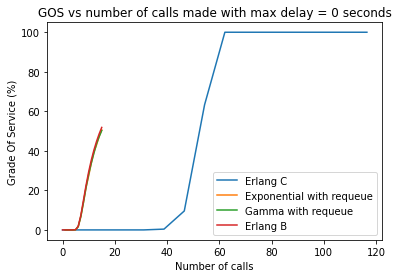

In [65]:
trafficRange = offeredTraffic(simulationCallAmounts,meanCallDuration)
plt.plot(trafficRange, np.clip(erlangCs,0,100), label='Erlang C')
plt.plot(trafficRange, np.clip(GOS_exp,0,100), label='Exponential with requeue')
plt.plot(trafficRange, np.clip(GOS_gamma,0,100), label='Gamma with requeue')
plt.plot(trafficRange, erlangBs, label='Erlang B')
# plt.plot(trafficRange, GOS_simulated, label='Exponential')

plt.xlabel('Number of calls')
plt.ylabel('Grade Of Service (%)')
plt.title("GOS vs number of calls made with max delay = {} seconds".format(str(maxDelay*3600)))
plt.legend()
plt.show()

# plt.plot(simulationCallAmounts, np.clip(meanCallDelays,0,1)*60, label='meanCallDelays')
# plt.plot(simulationCallAmounts, np.clip(meanQueuedDelays,0,1)*60, label='meanQueuedDelays')
# plt.xlabel('Number of calls')
# plt.ylabel('Mean Delay (mins)')
# plt.legend()
# plt.show()